<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<center><font size=10>Postgraduate Program in AI Agents for Business Applications</center></font>
<center><font size=6>Kartify Order Query ChatBot</center></font>

## **Key Points to Note**

* The objective of this week is to **<font color='#4682B4'>experience how businesses use Agentic AI</font>** with the tools and technologies involved to solve real-world problems.

* The focus of this week is not on understanding minute implementation details like code or syntax, but on **<font color='#4682B4'>grasping how an end-to-end Agentic AI system operates</font>**, the processes it follows, and the outcomes it delivers.

* Don’t worry about the specifics of how each component was built — **<font color='#4682B4'>you will gradually learn the underlying concepts and techniques throughout this program</font>**.

* Think of this week as a **preview of what you’ll be able to design and build using Agentic AI by the end of this program**.


# **Problem**

**Kartify seeks to enhance customer support, both in terms of quality and efficiency, in order-related queries. They require an AI-powered chatbot solution that leverages order and product information to deliver instant, accurate, and context-aware responses to customers.**

# **Agentic AI Solution Workflow**

## Business Context

In today’s fast-paced e-commerce environment, providing high-quality customer support is essential for enhancing customer satisfaction and loyalty. Kartify, a dynamic online retail platform, is committed to improving its customer service experience, particularly in handling order-related inquiries. However, with increasing order volumes and customer queries, the challenge of delivering timely and efficient responses has become increasingly complex.

To address this challenge, Kartify recognizes the need for an AI-powered chatbot solution. By leveraging order and product information, the chatbot will be designed to deliver instant, accurate, and context-aware responses to customer inquiries. This enhancement aims not only to streamline customer interactions but also to alleviate the workload on the support team, allowing human agents to focus on more complex inquiries that require personalized attention.

Through the implementation of this AI-driven solution, Kartify aims to create a seamless customer support experience that meets the expectations of modern consumers while optimizing operational efficiency.

## Problem Definition 

Kartify faces the challenge of effectively managing customer inquiries related to orders and products. Current manual methods of addressing these queries can lead to delays in response times and inconsistencies in the quality of information provided. As a result, there is a pressing need to develop a smart support system that can handle common questions related to order status, product details, returns, and other pertinent topics.

The key requirements for the chatbot solution include:

1. **Instant Response Capabilities**: The chatbot must be able to provide immediate answers to frequently asked questions regarding order statuses, product specifications, and policies, eliminating the need for customers to wait for human intervention.

2. **Context-Aware Responses**: The solution should utilize natural language processing (NLP) to understand the context of customer queries effectively, delivering personalized and relevant responses based on the customer's previous interactions and order history.

By achieving these, Kartify aspires to revolutionize its customer support approach, positioning itself as a customer-centric brand in the competitive e-commerce landscape and contributing to its long-term success in the marketplace.

# **Data Gathering**

In a full-scale deployment, a **Smart Order Query Assistant Bot** is expected to handle diverse customer queries, ranging from order status and shipping updates to returns and replacements, across multiple platforms. To ensure real-time, accurate, and personalized responses, such a system typically integrates with multiple external services like payment gateways, courier APIs, product catalogs, and customer support tools.


In the current scenario, we are building a **Smart Order Query Assistant Bot** designed to efficiently handle customer queries related to order status, delivery timelines, returns, replacements, and shipping details.

The system relies on a **single structured database** that contains all the essential information required for accurate query resolution, including:

* **Customer Information**: `customer_id`, `name`, `email`
* **Product Information**: `product_description`
* **Order Timeline**: `order_date`, `dispatch_date`, `expected_delivery`, `actual_delivery`
* **Payment and Status**: `payment_status`, `order_status`
* **Return and Replacement Policies**: `return_days_allowed`, `return_conditions`, `replacement_days_allowed`, `product_warranty`
* **Logistics Details**: `tracking_number`, `shipping_partner`



For the scope of this session, we are going to export a **sample of Kartify’s order database** to demonstrate the end-to-end Agentic AI solution.

We'll load this sample data into a Python notebook for illustration and simulate how the chatbot uses it to respond to real-world customer queries.


In [1]:
!pip install langgraph langchain langchain-openai langchain-core langchain-community grandalf

In [2]:
import json

In [21]:
"""
Kartify Order Query ChatBot - Multi-Agent System with SQL Agent
Uses SQLite database instead of mock data
"""

# ============================================================================
# IMPORTS
# ============================================================================
from typing import TypedDict, Annotated, Sequence, Literal
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import create_sql_agent
import operator
from datetime import datetime, timedelta
import json
import os
import sqlite3

# ============================================================================
# CONFIGURATION
# ============================================================================
def load_config():
    """Load API credentials from config.json"""
    try:
        file_name = 'config.json'
        with open(file_name, 'r') as file:
            config = json.load(file)
            API_KEY = config.get("API_KEY")
            OPENAI_API_BASE = config.get("OPENAI_API_BASE")

            os.environ['OPENAI_API_KEY'] = API_KEY
            if OPENAI_API_BASE:
                os.environ["OPENAI_API_BASE"] = OPENAI_API_BASE

            print("✓ API credentials loaded successfully")
            return True
    except Exception as e:
        print(f"⚠ Error loading config: {str(e)}")
        return False

config_loaded = load_config()

✓ API credentials loaded successfully


In [22]:

# ============================================================================
# STATE DEFINITION
# ============================================================================
class ChatBotState(TypedDict):
    """State shared across all agents"""
    messages: Annotated[Sequence[BaseMessage], operator.add]
    customer_query: str
    order_id: str | None
    order_data: dict | None
    product_data: dict | None
    quality_check_result: dict | None
    replacement_result: dict | None
    next_agent: str
    final_response: str | None

# ============================================================================
# SQL DATABASE SERVICES
# ============================================================================
class SQLOrderService:
    """Service for querying orders from SQLite database"""

    def __init__(self, db_path='orders.db'):
        self.db_path = db_path
        self.db = SQLDatabase.from_uri(f"sqlite:///{db_path}")
        self.llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    def get_order(self, order_id: str) -> dict | None:
        """Get order details using SQL query"""
        try:
            conn = sqlite3.connect(self.db_path)
            conn.row_factory = sqlite3.Row
            cursor = conn.cursor()

            # Query order with customer info
            cursor.execute('''
                SELECT
                    o.order_id,
                    o.order_date,
                    o.status,
                    o.delivery_date,
                    o.total_amount,
                    o.shipping_address,
                    o.payment_method,
                    c.name as customer_name,
                    c.email as customer_email
                FROM orders o
                JOIN customers c ON o.customer_id = c.customer_id
                WHERE o.order_id = ?
            ''', (order_id,))

            order_row = cursor.fetchone()

            if not order_row:
                conn.close()
                return None

            # Query order items
            cursor.execute('''
                SELECT
                    oi.product_id,
                    p.name,
                    oi.quantity,
                    oi.price_at_purchase
                FROM order_items oi
                JOIN products p ON oi.product_id = p.product_id
                WHERE oi.order_id = ?
            ''', (order_id,))

            items_rows = cursor.fetchall()

            # Build order dictionary
            order_data = {
                "order_id": order_row["order_id"],
                "customer_name": order_row["customer_name"],
                "customer_email": order_row["customer_email"],
                "order_date": order_row["order_date"],
                "status": order_row["status"],
                "delivery_date": order_row["delivery_date"],
                "total": order_row["total_amount"],
                "shipping_address": order_row["shipping_address"],
                "payment_method": order_row["payment_method"],
                "items": [
                    {
                        "product_id": row["product_id"],
                        "name": row["name"],
                        "quantity": row["quantity"],
                        "price": row["price_at_purchase"]
                    }
                    for row in items_rows
                ]
            }

            conn.close()
            return order_data

        except Exception as e:
            print(f"Error querying order: {str(e)}")
            return None

    def search_orders_by_customer(self, customer_name: str) -> list:
        """Search orders by customer name"""
        try:
            conn = sqlite3.connect(self.db_path)
            conn.row_factory = sqlite3.Row
            cursor = conn.cursor()

            cursor.execute('''
                SELECT o.order_id, o.status, o.order_date, o.total_amount
                FROM orders o
                JOIN customers c ON o.customer_id = c.customer_id
                WHERE c.name LIKE ?
                ORDER BY o.order_date DESC
            ''', (f'%{customer_name}%',))

            orders = [dict(row) for row in cursor.fetchall()]
            conn.close()
            return orders

        except Exception as e:
            print(f"Error searching orders: {str(e)}")
            return []


class SQLProductService:
    """Service for querying products from SQLite database"""

    def __init__(self, db_path='orders.db'):
        self.db_path = db_path

    def get_product(self, product_id: str) -> dict | None:
        """Get product details using SQL query"""
        try:
            conn = sqlite3.connect(self.db_path)
            conn.row_factory = sqlite3.Row
            cursor = conn.cursor()

            cursor.execute('''
                SELECT
                    product_id,
                    name,
                    description,
                    price,
                    warranty_period,
                    return_policy,
                    battery_life,
                    connectivity,
                    weight,
                    water_resistance,
                    display,
                    category,
                    stock_quantity
                FROM products
                WHERE product_id = ?
            ''', (product_id,))

            row = cursor.fetchone()
            conn.close()

            if not row:
                return None

            # Build specifications dict
            specs = {}
            if row["battery_life"]:
                specs["battery_life"] = row["battery_life"]
            if row["connectivity"]:
                specs["connectivity"] = row["connectivity"]
            if row["weight"]:
                specs["weight"] = row["weight"]
            if row["water_resistance"]:
                specs["water_resistance"] = row["water_resistance"]
            if row["display"]:
                specs["display"] = row["display"]

            return {
                "product_id": row["product_id"],
                "name": row["name"],
                "description": row["description"],
                "price": row["price"],
                "warranty": row["warranty_period"],
                "return_policy": row["return_policy"],
                "category": row["category"],
                "stock_quantity": row["stock_quantity"],
                "specifications": specs
            }

        except Exception as e:
            print(f"Error querying product: {str(e)}")
            return None


class ReplacementService:
    """Service for creating replacement orders"""

    def __init__(self, db_path='orders.db'):
        self.db_path = db_path

    def create_replacement(self, order_id: str, reason: str) -> dict:
        """Create a replacement order in the database"""
        replacement_id = f"REP{order_id[3:]}"

        try:
            conn = sqlite3.connect(self.db_path)
            cursor = conn.cursor()

            # In a real system, you would:
            # 1. Create a new order record
            # 2. Link it to the original order
            # 3. Update inventory
            # 4. Send notifications

            # For now, we'll just return the replacement info
            conn.close()

            return {
                "replacement_id": replacement_id,
                "original_order_id": order_id,
                "status": "Initiated",
                "estimated_delivery": (datetime.now() + timedelta(days=5)).strftime("%Y-%m-%d"),
                "tracking_number": f"TRK{replacement_id}",
                "reason": reason
            }

        except Exception as e:
            print(f"Error creating replacement: {str(e)}")
            return None

In [ ]:
# class OrchestratorAgent:
#     """LLM-driven orchestrator for Kartify support"""

#     def __init__(self, llm):
#         self.llm = llm
#         self.prompt = ChatPromptTemplate.from_messages([
#             (
#                 "system",
#                 """You are the orchestrator for Kartify's support workflow.
#                 Your job is to decide which agent should act next based on query and context.

#                 Agents:
#                 - order_retrieval → Fetch order info (only if order_data is missing)
#                 - product_info → Get product details (only if product_data is missing)
#                 - quality_check → Check damage/replacement eligibility
#                 - replacement_processing → Create replacement order
#                 - response_generation → Generate final reply

#                 Rules:
#                 - If order_data exists, NEVER call order_retrieval again.
#                 - Pick the **next most logical agent** to progress toward resolving the customer’s request.
#                 - If order_data exists and no replacement/damage mentioned, go directly to response_generation.
#                 - Output only the agent name in lowercase.
#                 """
#             ),
#             (
#                 "human",
#                 """Customer Query:
#                 {query}

#                 Context:
#                 - Has order data: {has_order}
#                 - Has product data: {has_product}
#                 - Has quality check: {has_quality}
#                 - Has replacement: {has_replacement}

#                 Next agent:"""
#             )
#         ])

#     def process(self, state: ChatBotState) -> ChatBotState:
#         query = state.get("customer_query", "")
#         has_order = state.get("order_data") is not None
#         has_product = state.get("product_data") is not None
#         has_quality = state.get("quality_check_result") is not None
#         has_replacement = state.get("replacement_result") is not None

#         # 🧠 Ask LLM for routing suggestion
#         chain = self.prompt | self.llm
#         response = chain.invoke({
#             "query": query,
#             "has_order": has_order,
#             "has_product": has_product,
#             "has_quality": has_quality,
#             "has_replacement": has_replacement
#         })

#         next_agent = response.content.strip().lower().replace(" ", "_")

#         # 🚧 Guardrails to prevent infinite loops
#         if has_order and next_agent == "order_retrieval":
#             # We already have the order, no need to fetch again
#             next_agent = "response_generation"

#         # If all needed info is available, go to response generation
#         if has_order and not ("replace" in query.lower() or "damage" in query.lower()):
#             next_agent = "response_generation"

#         # Default fallback
#         allowed_agents = [
#             "order_retrieval", "product_info", "quality_check",
#             "replacement_processing", "response_generation"
#         ]
#         if next_agent not in allowed_agents:
#             next_agent = "response_generation"

#         state["next_agent"] = next_agent
#         return state





# class OrchestratorAgent:
#     """LLM-driven orchestrator for Kartify support — with recursion safety and vague query fallback"""

#     def __init__(self, llm):
#         self.llm = llm
#         self.prompt = ChatPromptTemplate.from_messages([
#             (
#                 "system",
#                 """You are the orchestrator for Kartify's support workflow.
#                 Your job is to decide which agent should act next based on the customer query and current context.

#                 Available agents:
#                 - order_retrieval → Fetch order info (only if order_data is missing)
#                 - product_info → Get product details (only if product_data is missing)
#                 - quality_check → Check damage/replacement eligibility
#                 - replacement_processing → Create replacement order
#                 - response_generation → Generate final reply to the customer

#                 Rules:
#                 - NEVER call order_retrieval again if order_data already exists.
#                 - Pick the next most logical agent to resolve the customer's request.
#                 - If order_data exists and there is no mention of damage, replacement, or issue → go directly to response_generation.
#                 - If the query is vague, unrelated, or unclear → route to response_generation.
#                 - Output ONLY the agent name (lowercase, underscore format). Example: response_generation
#                 """
#             ),
#             (
#                 "human",
#                 """Customer Query:
#                 {query}

#                 Context:
#                 - Has order data: {has_order}
#                 - Has product data: {has_product}
#                 - Has quality check: {has_quality}
#                 - Has replacement: {has_replacement}

#                 Next agent:"""
#             )
#         ])

#     def process(self, state: ChatBotState) -> ChatBotState:
#         query = state.get("customer_query", "").strip()
#         has_order = state.get("order_data") is not None
#         has_product = state.get("product_data") is not None
#         has_quality = state.get("quality_check_result") is not None
#         has_replacement = state.get("replacement_result") is not None

#         # --- Guard for vague or empty queries ---
#         if not query or len(query.split()) < 2:
#             state["next_agent"] = "response_generation"
#             return state

#         # --- Ask LLM for routing suggestion ---
#         try:
#             chain = self.prompt | self.llm
#             response = chain.invoke({
#                 "query": query,
#                 "has_order": has_order,
#                 "has_product": has_product,
#                 "has_quality": has_quality,
#                 "has_replacement": has_replacement
#             })
#             next_agent = response.content.strip().lower().replace(" ", "_")
#         except Exception:
#             # Fallback in case of LLM or chain failure
#             next_agent = "response_generation"

#         # --- Guardrails to prevent recursion ---
#         allowed_agents = [
#             "order_retrieval", "product_info", "quality_check",
#             "replacement_processing", "response_generation"
#         ]

#         # If LLM outputs something invalid, fallback to response_generation
#         if next_agent not in allowed_agents:
#             next_agent = "response_generation"

#         # Prevent redundant retrieval
#         if has_order and next_agent == "order_retrieval":
#             next_agent = "response_generation"

#         # Force direct reply for vague or non-specific queries
#         vague_terms = ["hi", "hello", "hey", "thank", "ok", "okay", "yes", "no", "fine"]
#         if any(word in query.lower().split() for word in vague_terms):
#             next_agent = "response_generation"

#         # If order exists and no damage/return context → respond directly
#         if has_order and not any(
#             word in query.lower() for word in ["damage", "broken", "replace", "return"]
#         ):
#             next_agent = "response_generation"

#         # Assign final route
#         state["next_agent"] = next_agent
#         return state

In [ ]:

class OrchestratorAgent:
    """LLM-driven orchestrator for Kartify support — recursion-safe, context-aware routing"""

    def __init__(self, llm):
        self.llm = llm
        self.prompt = ChatPromptTemplate.from_messages([
            (
                "system",
                """You are the orchestrator for Kartify's support workflow.
                Decide which agent should act next based on the customer's message and context.

                Agents:
                - order_retrieval → Fetch order info (only if missing)
                - product_info → Get product details (only if missing)
                - quality_check → Check damage/replacement eligibility
                - replacement_processing → Create replacement or reorder
                - response_generation → Generate final reply

                Rules:
                - Never call order_retrieval if order_data already exists.
                - If order_data exists and the issue seems resolved or non-specific → go to response_generation.
                - If the query confirms an action (like 'yes', 'please assist', 'go ahead') → route to replacement_processing.
                - If the query is vague, greeting, or unrelated → route to response_generation.
                - Always output ONLY the agent name (lowercase, underscore format).
                """
            ),
            (
                "human",
                """Customer Query:
                {query}

                Context:
                - Has order data: {has_order}
                - Has product data: {has_product}
                - Has quality check: {has_quality}
                - Has replacement: {has_replacement}

                Next agent:"""
            )
        ])

    def process(self, state: ChatBotState) -> ChatBotState:
        query = state.get("customer_query", "").strip().lower()
        has_order = state.get("order_data") is not None
        has_product = state.get("product_data") is not None
        has_quality = state.get("quality_check_result") is not None
        has_replacement = state.get("replacement_result") is not None

        # --- Explicit handling for confirmations and vague responses ---
        confirm_words = [
            "yes", "sure", "okay", "ok", "please assist", "go ahead",
            "do it", "help me", "confirm", "proceed", "yeah"
        ]
        vague_words = [
            "hi", "hello", "thanks", "thank you", "fine", "good", "no"
        ]

        if any(word in query for word in confirm_words):
            next_agent = "replacement_processing"
        elif any(word in query.split() for word in vague_words) or not query:
            next_agent = "response_generation"
        else:
            # --- Use LLM for complex routing decisions ---
            chain = self.prompt | self.llm
            try:
                response = chain.invoke({
                    "query": query,
                    "has_order": has_order,
                    "has_product": has_product,
                    "has_quality": has_quality,
                    "has_replacement": has_replacement
                })
                next_agent = response.content.strip().lower().replace(" ", "_")
            except Exception:
                next_agent = "response_generation"

        # --- Guardrails to prevent loops ---
        allowed_agents = [
            "order_retrieval", "product_info", "quality_check",
            "replacement_processing", "response_generation"
        ]
        if next_agent not in allowed_agents:
            next_agent = "response_generation"

        # --- Final logic cleanup ---
        if has_order and next_agent == "order_retrieval":
            next_agent = "response_generation"

        # If all info exists and no issue keywords → go straight to response_generation
        if has_order and not any(
            k in query for k in ["damage", "broken", "replace", "cancel", "reorder"]
        ):
            if next_agent != "replacement_processing":
                next_agent = "response_generation"

        # ✅ Save the next step
        state["next_agent"] = next_agent
        return state



class OrderRetrievalAgent:
    """Retrieves order information from SQL database"""

    def __init__(self, llm):
        self.llm = llm
        self.order_service = SQLOrderService()
        self.prompt = ChatPromptTemplate.from_messages([
            ("system", """Extract the order ID from the customer query.
            Look for patterns like ORD followed by numbers (e.g., ORD12345).
            Return ONLY the order ID in format ORDXXXXX or the word 'NOT_FOUND' if no order ID is present.
            Do not include any other text."""),
            ("human", "{query}")
        ])

    def process(self, state: ChatBotState) -> ChatBotState:
        chain = self.prompt | self.llm
        response = chain.invoke({"query": state["customer_query"]})
        order_id = response.content.strip()

        if order_id != "NOT_FOUND" and "ORD" in order_id.upper():
            order_data = self.order_service.get_order(order_id.upper())
            state["order_id"] = order_id.upper()
            state["order_data"] = order_data

        state["next_agent"] = "orchestrator"
        return state


class ProductInfoAgent:
    """Retrieves product information from SQL database"""

    def __init__(self):
        self.product_service = SQLProductService()

    def process(self, state: ChatBotState) -> ChatBotState:
        if state.get("order_data"):
            items = state["order_data"].get("items", [])
            product_data = []

            for item in items:
                product_id = item.get("product_id")
                if product_id:
                    product = self.product_service.get_product(product_id)
                    if product:
                        product_data.append(product)

            state["product_data"] = product_data

        state["next_agent"] = "orchestrator"
        return state


class QualityCheckAgent:
    """Checks if order qualifies for replacement"""

    def __init__(self, llm):
        self.llm = llm
        self.prompt = ChatPromptTemplate.from_messages([
            ("system", """Analyze if the customer query mentions any product issues.
            Look for keywords like: damaged, defective, broken, wrong item, not working, faulty, quality issues.
            Respond with only 'YES' if issues are mentioned, or 'NO' if not."""),
            ("human", "{query}")
        ])

    def process(self, state: ChatBotState) -> ChatBotState:
        if not state.get("order_data"):
            state["quality_check_result"] = {
                "eligible": False,
                "reason": "No order data available",
                "issues": []
            }
        else:
            order_data = state["order_data"]
            is_delivered = order_data.get("status") == "Delivered"

            delivery_date_str = order_data.get("delivery_date")
            within_window = False
            if delivery_date_str:
                delivery_date = datetime.strptime(delivery_date_str, "%Y-%m-%d")
                days_since_delivery = (datetime.now() - delivery_date).days
                within_window = days_since_delivery <= 30

            chain = self.prompt | self.llm
            response = chain.invoke({"query": state["customer_query"]})
            has_valid_reason = response.content.strip().upper() == "YES"

            eligible = is_delivered and within_window and has_valid_reason

            issues = []
            if has_valid_reason:
                query_lower = state["customer_query"].lower()
                if "damaged" in query_lower or "damage" in query_lower:
                    issues.append("Product damaged")
                if "defective" in query_lower or "broken" in query_lower:
                    issues.append("Product defective")
                if "wrong" in query_lower:
                    issues.append("Wrong item received")
                if not issues:
                    issues.append("Quality issue reported")

            state["quality_check_result"] = {
                "eligible": eligible,
                "reason": f"Delivered: {is_delivered}, Within window: {within_window}, Valid reason: {has_valid_reason}",
                "issues": issues,
                "days_since_delivery": (datetime.now() - delivery_date).days if delivery_date_str else None
            }

        state["next_agent"] = "orchestrator"
        return state


# class ReplacementProcessingAgent:
#     """Processes replacement requests"""

#     def __init__(self):
#         self.replacement_service = ReplacementService()

#     def process(self, state: ChatBotState) -> ChatBotState:
#         quality_check = state.get("quality_check_result", {})

#         if quality_check.get("eligible"):
#             order_id = state.get("order_id")
#             reason = ", ".join(quality_check.get("issues", ["Customer request"]))
#             replacement_result = self.replacement_service.create_replacement(order_id, reason)
#             state["replacement_result"] = replacement_result

#         state["next_agent"] = "response_generation"
#         return state


# class ResponseGenerationAgent:
#     """Generates final customer response"""

#     def __init__(self, llm):
#         self.llm = llm
#         self.prompt = ChatPromptTemplate.from_messages([
#             ("system", """You are a friendly Kartify customer support agent.
#             Generate a natural, empathetic response based on the gathered information.
#             Be helpful, professional, and address the customer's concerns directly.

#             Available Information:
#             - Customer Query: {query}
#             - Order Data: {order_data}
#             - Product Data: {product_data}
#             - Quality Check: {quality_check}
#             - Replacement Result: {replacement_result}"""),
#             ("human", "Generate a helpful response for the customer.")
#         ])

#     def process(self, state: ChatBotState) -> ChatBotState:
#         chain = self.prompt | self.llm
#         response = chain.invoke({
#             "query": state["customer_query"],
#             "order_data": str(state.get("order_data", "No order data")),
#             "product_data": str(state.get("product_data", "No product data")),
#             "quality_check": str(state.get("quality_check_result", "No quality check performed")),
#             "replacement_result": str(state.get("replacement_result", "No replacement created"))
#         })

#         state["final_response"] = response.content
#         state["next_agent"] = "end"

#         return state


class ReplacementProcessingAgent:
    """Processes replacement or reorder requests safely"""

    def __init__(self):
        self.replacement_service = ReplacementService()

    def process(self, state: ChatBotState) -> ChatBotState:
        # --- Retrieve current state data safely ---
        quality_check = state.get("quality_check_result") or {}
        order_data = state.get("order_data")
        order_id = state.get("order_id")

        # --- Guard: ensure order details exist ---
        if not order_data or not order_id:
            state["final_response"] = (
                "I couldn’t find your order details. Could you please provide your order ID so I can help with the replacement?"
            )
            state["next_agent"] = "response_generation"
            return state

        # --- Determine reason and eligibility ---
        eligible = isinstance(quality_check, dict) and quality_check.get("eligible", False)
        reason = ", ".join(quality_check.get("issues", [])) if quality_check else "Customer requested reorder"

        # --- Create replacement or reorder record ---
        if eligible or "reorder" in state.get("customer_query", "").lower() or "assist" in state.get("customer_query", "").lower():
            replacement_result = self.replacement_service.create_replacement(order_id, reason)
            state["replacement_result"] = replacement_result
        else:
            # Not eligible — fallback message
            state["replacement_result"] = {
                "replacement_id": None,
                "status": "Not Eligible",
                "reason": reason
            }
            state["final_response"] = (
                "It looks like this order may not be eligible for a replacement. "
                "Could you please confirm if you'd like to reorder these items instead?"
            )

        # --- Always proceed to response generation ---
        state["next_agent"] = "response_generation"
        return state


class ResponseGenerationAgent:
    """Generates the final customer-facing response for Kartify support.
    Always produces a helpful, empathetic, and complete answer — even with minimal data.
    """

    def __init__(self, llm):
        self.llm = llm
        self.prompt = ChatPromptTemplate.from_messages([
            (
                "system",
                """You are a warm, professional customer support representative for Kartify.
                Your goal is to provide a clear, empathetic, and helpful response based on all available context.

                Guidelines:
                - Be natural, polite, and solution-oriented.
                - Always acknowledge the customer’s concern.
                - If information is incomplete or unclear, politely ask for clarification.
                - If the query is vague (e.g., greetings or thanks), respond appropriately and keep it brief.
                - If the issue is resolved (replacement or confirmation given), close the conversation positively.
                - NEVER say you are an AI — respond as a human Kartify support agent.
                - Always end on a reassuring, customer-friendly note, but DO NOT include a personal name or signature line.

                Information you can use:
                - Customer Query: {query}
                - Order Data: {order_data}
                - Product Data: {product_data}
                - Quality Check Result: {quality_check}
                - Replacement Result: {replacement_result}
                """
            ),
            (
                "human",
                """Based on the above context, write a clear, kind, and helpful response for the customer.
                The message should sound natural, empathetic, and directly address their concern."""
            )
        ])

    def process(self, state: ChatBotState) -> ChatBotState:
        """Generate a friendly, fallback-safe customer response."""

        query = state.get("customer_query", "").strip()
        order_data = str(state.get("order_data", "No order data"))
        product_data = str(state.get("product_data", "No product data"))
        quality_check = str(state.get("quality_check_result", "No quality check performed"))
        replacement_result = str(state.get("replacement_result", "No replacement created"))

        # 🛡️ Handle vague or empty queries before calling LLM
        vague_terms = ["hi", "hello", "hey", "thanks", "thank you", "ok", "okay"]
        if not query or query.lower().strip() in vague_terms:
            response_text = "Hi there! 😊 How can I assist you with your Kartify order today?"
        else:
            try:
                chain = self.prompt | self.llm
                response = chain.invoke({
                    "query": query,
                    "order_data": order_data,
                    "product_data": product_data,
                    "quality_check": quality_check,
                    "replacement_result": replacement_result
                })
                response_text = response.content.strip()
            except Exception as e:
                # 🧩 Safe fallback if LLM call fails
                response_text = (
                    "I'm sorry, something went wrong while preparing your response. "
                    "Could you please rephrase or provide a bit more detail about your concern?"
                )

        # 🧠 Ensure a final response always exists
        if not response_text or response_text.strip() == "":
            response_text = "I’m here to help with your Kartify order. Could you please clarify your request?"

        # 💬 Save the final message and signal end of flow
        state["final_response"] = response_text
        state["next_agent"] = None  # 'None' or 'end' → terminate the graph safely

        return state


In [40]:
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI  # ✅ new import path
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import BaseMessage
from langchain_community.utilities import SQLDatabase
from typing import Annotated, Sequence, TypedDict
import sqlite3, operator
from datetime import datetime, timedelta


# ================================================================
# Initialize LLM and agents
# ================================================================
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

orchestrator = OrchestratorAgent(llm)
order_agent = OrderRetrievalAgent(llm)
product_agent = ProductInfoAgent()
quality_agent = QualityCheckAgent(llm)
replacement_agent = ReplacementProcessingAgent()
response_agent = ResponseGenerationAgent(llm)

# ================================================================
# Define node functions
# ================================================================
def orchestrator_node(state: ChatBotState):
    return orchestrator.process(state)

def order_node(state: ChatBotState):
    return order_agent.process(state)

def product_node(state: ChatBotState):
    return product_agent.process(state)

def quality_node(state: ChatBotState):
    return quality_agent.process(state)

def replacement_node(state: ChatBotState):
    return replacement_agent.process(state)

def response_node(state: ChatBotState):
    return response_agent.process(state)

# ================================================================
# Build the LangGraph workflow
# ================================================================
workflow = StateGraph(ChatBotState)

workflow.add_node("orchestrator", orchestrator_node)
workflow.add_node("order_retrieval", order_node)
workflow.add_node("product_info", product_node)
workflow.add_node("quality_check", quality_node)
workflow.add_node("replacement_processing", replacement_node)
workflow.add_node("response_generation", response_node)

# Static edges
workflow.add_edge("order_retrieval", "orchestrator")
workflow.add_edge("product_info", "orchestrator")
workflow.add_edge("quality_check", "orchestrator")
workflow.add_edge("replacement_processing", "response_generation")
workflow.add_edge("response_generation", END)

# Dynamic routing
def route_next(state: ChatBotState):
    return state["next_agent"]

workflow.add_conditional_edges(
    "orchestrator",
    route_next,
    {
        "order_retrieval": "order_retrieval",
        "product_info": "product_info",
        "quality_check": "quality_check",
        "replacement_processing": "replacement_processing",
        "response_generation": "response_generation",
        "end": END
    }
)

# Compile graph
workflow.set_entry_point("orchestrator")
graph = workflow.compile()


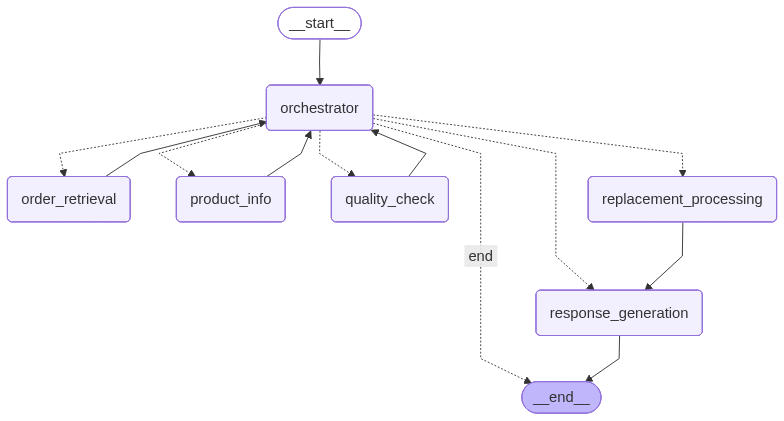

In [41]:
from IPython.display import Image, display

# Render the workflow diagram for your compiled LangGraph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Diagram rendering failed:", e)


In [26]:
initial_state: ChatBotState = {
    "messages": [],
    "customer_query": "Hi, my order ORD1001 arrived damaged. Can I get a replacement?",
    "order_id": None,
    "order_data": None,
    "product_data": None,
    "quality_check_result": None,
    "replacement_result": None,
    "next_agent": "orchestrator",
    "final_response": None
}

final_state = graph.invoke(initial_state)

print("\n==============================")
print("🤖 Final Customer Response:")
print("==============================\n")
print(final_state["final_response"])

print("\n📦 Order Details Fetched:")
print("==============================")
print(final_state["order_data"])



🤖 Final Customer Response:

Hi Ethan,

Thank you for reaching out to us, and I'm really sorry to hear that your order (ORD1001) arrived damaged. I understand how frustrating this must be for you, and I want to help resolve this issue as quickly as possible.

Unfortunately, it looks like your order is still in the processing stage and hasn't been delivered yet, which means we can't initiate a replacement at this time. However, once your order is delivered, if you find that the items are damaged, please let us know right away, and we will assist you with the replacement process.

If you have any further questions or need assistance with anything else, please feel free to reach out. We're here to help!

Best regards,  
[Your Name]  
Kartify Customer Support

📦 Order Details Fetched:
{'order_id': 'ORD1001', 'customer_name': 'Ethan Hunt', 'customer_email': 'ethan.h@example.com', 'order_date': '2025-10-05', 'status': 'Processing', 'delivery_date': None, 'total': 1598.99, 'shipping_address':

In [ ]:
initial_state: ChatBotState = {
    "messages": [],
    "customer_query": "Can you confirm when my Smartwatch X from order ORD1001 will be delivered?",
    "order_id": None,
    "order_data": None,
    "product_data": None,
    "quality_check_result": None,
    "replacement_result": None,
    "next_agent": "orchestrator",
    "final_response": None
}

final_state = graph.invoke(initial_state)

print("\n==============================")
print("🤖 Final Customer Response:")
print("==============================\n")
print(final_state["final_response"])

print("\n📦 Order Details Fetched:")
print("==============================")
print(final_state["order_data"])


In [ ]:
initial_state: ChatBotState = {
    "messages": [],
    "customer_query": "Hey, I want to cancel my order ORD1002 before it ships. Is that possible?",
    "order_id": None,
    "order_data": None,
    "product_data": None,
    "quality_check_result": None,
    "replacement_result": None,
    "next_agent": "orchestrator",
    "final_response": None
}

final_state = graph.invoke(initial_state)

print("\n==============================")
print("🤖 Final Customer Response:")
print("==============================\n")
print(final_state["final_response"])

print("\n📦 Order Details Fetched:")
print("==============================")
print(final_state["order_data"])


In [ ]:
initial_state: ChatBotState = {
    "messages": [],
    "customer_query": "What is the status of my order ORD1002 ?",
    "order_id": None,
    "order_data": None,
    "product_data": None,
    "quality_check_result": None,
    "replacement_result": None,
    "next_agent": "orchestrator",
    "final_response": None
}

final_state = graph.invoke(initial_state)

print("\n==============================")
print("🤖 Final Customer Response:")
print("==============================\n")
print(final_state["final_response"])

print("\n📦 Order Details Fetched:")
print("==============================")
print(final_state["order_data"])


In [ ]:
initial_state: ChatBotState = {
    "messages": [],
    "customer_query": "Hi, my 4K Monitor 27 order (ORD1003) hasn’t been delivered yet. Can you check the status?",
    "order_id": None,
    "order_data": None,
    "product_data": None,
    "quality_check_result": None,
    "replacement_result": None,
    "next_agent": "orchestrator",
    "final_response": None
}

final_state = graph.invoke(initial_state)

print("\n==============================")
print("🤖 Final Customer Response:")
print("==============================\n")
print(final_state["final_response"])

print("\n📦 Order Details Fetched:")
print("==============================")
print(final_state["order_data"])


In [ ]:
initial_state: ChatBotState = {
    "messages": [],
    "customer_query": "I returned my Portable Blender from order ORD1004. When will I get my refund?",
    "order_id": None,
    "order_data": None,
    "product_data": None,
    "quality_check_result": None,
    "replacement_result": None,
    "next_agent": "orchestrator",
    "final_response": None
}

final_state = graph.invoke(initial_state)

print("\n==============================")
print("🤖 Final Customer Response:")
print("==============================\n")
print(final_state["final_response"])

print("\n📦 Order Details Fetched:")
print("==============================")
print(final_state["order_data"])


In [ ]:
initial_state: ChatBotState = {
    "messages": [],
    "customer_query": "Can you send me a replacement for the returned product in ORD1004 instead of a refund?",
    "order_id": None,
    "order_data": None,
    "product_data": None,
    "quality_check_result": None,
    "replacement_result": None,
    "next_agent": "orchestrator",
    "final_response": None
}

final_state = graph.invoke(initial_state)

print("\n==============================")
print("🤖 Final Customer Response:")
print("==============================\n")
print(final_state["final_response"])

print("\n📦 Order Details Fetched:")
print("==============================")
print(final_state["order_data"])


In [ ]:
initial_state: ChatBotState = {
    "messages": [],
    "customer_query": "My order ORD1005 was cancelled. Can I reorder the same products?",
    "order_id": None,
    "order_data": None,
    "product_data": None,
    "quality_check_result": None,
    "replacement_result": None,
    "next_agent": "orchestrator",
    "final_response": None
}

final_state = graph.invoke(initial_state)

print("\n==============================")
print("🤖 Final Customer Response:")
print("==============================\n")
print(final_state["final_response"])

print("\n📦 Order Details Fetched:")
print("==============================")
print(final_state["order_data"])


# Infinite loop for Customer

In [44]:
# # Infinite chatbot loop

# while True:
#     # Take customer query
#     customer_query = input("\n🗣️ Customer: ")

#     # Check for exit condition
#     if customer_query.lower() in ["quit", "exit", "bye"]:
#         print("\n👋 Chatbot: Thank you! Have a great day.")
#         break

#     # Define initial chatbot state
#     initial_state: ChatBotState = {
#         "messages": [],
#         "customer_query": customer_query,
#         "order_id": None,
#         "order_data": None,
#         "product_data": None,
#         "quality_check_result": None,
#         "replacement_result": None,
#         "next_agent": "orchestrator",
#         "final_response": None
#     }

#     # Invoke the chatbot graph (your workflow or pipeline)
#     final_state = graph.invoke(initial_state)

#     # Display chatbot response
#     print("\n🤖 Chatbot:", final_state["final_response"])

#     # Optionally display other details for debugging
#     if final_state.get("order_data"):
#         print("\n📦 Order Details:", final_state["order_data"])


In [46]:
# 🧠 Initialize chatbot memory (state persists between turns)
chatbot_state: ChatBotState = {
    "messages": [],
    "customer_query": None,
    "order_id": None,
    "order_data": None,
    "product_data": None,
    "quality_check_result": None,
    "replacement_result": None,
    "next_agent": "orchestrator",
    "final_response": None
}

# 🔁 Infinite chatbot loop with memory
while True:
    customer_query = input("\n🗣️ Customer: ")

    # Exit condition
    if customer_query.lower() in ["quit", "exit", "bye"]:
        print("\n👋 Chatbot: Thank you! Have a great day.")
        break

    # 🧩 Update memory with new query
    chatbot_state["customer_query"] = customer_query
    chatbot_state["messages"].append({"role": "user", "content": customer_query})

    # 🧠 Invoke the chatbot workflow with memory
    chatbot_state = graph.invoke(chatbot_state)

    # 💬 Store assistant’s reply in memory
    chatbot_state["messages"].append({
        "role": "assistant",
        "content": chatbot_state["final_response"]
    })

    # Display chatbot response
    print("\n🤖 Chatbot:", chatbot_state["final_response"])

    # Optionally display other details for debugging
    if chatbot_state.get("order_data"):
        print("\n📦 Order Details:", chatbot_state["order_data"])



🤖 Chatbot: Hi Alice,

Thank you for reaching out about your order, ORD1006. I understand how important it is to stay updated on your purchases.

Unfortunately, I see that your order has been cancelled. If you have any questions about the cancellation or if there's anything else I can assist you with, please let me know. I'm here to help!

Thank you for your understanding, and I hope to assist you with your future orders.

Best regards,  
[Your Name]  
Kartify Customer Support

📦 Order Details: {'order_id': 'ORD1006', 'customer_name': 'Alice Johnson', 'customer_email': 'alice.j@example.com', 'order_date': '2025-08-09', 'status': 'Cancelled', 'delivery_date': None, 'total': 1599.96, 'shipping_address': '202 Maple Dr, Everywhere, USA', 'payment_method': 'PayPal', 'items': [{'product_id': 'P001', 'name': 'Smartwatch X', 'quantity': 2, 'price': 299.99}, {'product_id': 'P003', 'name': 'Ergonomic Office Chair', 'quantity': 2, 'price': 450.0}, {'product_id': 'P005', 'name': 'Portable Blender'